In [1]:
import sys
import jax
import os
import time
import genjax
import bayes3d as b
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")
from viz import *
from utils import *
from mcs_utils import *
from PIL import Image
import bayes3d.transforms_3d as t3d
from jax.debug import print as jprint
from tqdm import tqdm
import jax.tree_util as jtu
from genjax._src.core.transforms.incremental import NoChange, UnknownChange, Diff
console = genjax.pretty()
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Loading and preprocessing all data and renderer
SCALE = 0.1
cam_pose = CAM_POSE_CV2
inverse_cam_pose = jnp.linalg.inv(CAM_POSE_CV2)
observations = load_observations_npz('passive_physics_validation_object_permanence_0001_01')
(gt_images, gt_images_bg, gt_images_obj, intrinsics),(gt_images_orig, gt_images_bg_orig, gt_images_obj_orig, intrinsics_orig), registered_objects = preprocess_mcs_physics_scene(observations, MIN_DIST_THRESH=0.6, scale=SCALE)

Extracting Meshes


 54%|█████▍    | 129/240 [00:07<00:02, 45.67it/s]

Adding review


 56%|█████▌    | 134/240 [00:15<00:48,  2.18it/s]

Review passed, added to init queue
Adding new mesh for t = {} 132


100%|██████████| 240/240 [00:33<00:00,  7.09it/s]


Extracting downsampled data


In [3]:
b.setup_renderer(intrinsics)
for registered_obj in registered_objects:
    b.RENDERER.add_mesh(registered_obj['mesh'])
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/sphere.obj")
                                  , scaling_factor=0.1, mesh_name = "cube")
video_from_rendered(gt_images, scale = int(1/SCALE), framerate=30)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)
Centering mesh with translation [ 0.00250025  0.00500003 -0.00500049]


<IPython.core.display.HTML object>

In [52]:
# model time!

def get_bottom_most_height(i, world_pose):
    # Half dimensions to get the corner points relative to the center
    rotation_matrix = world_pose[:3,:3]
    center = world_pose[:3,3]
    dimensions = b.RENDERER.model_box_dims[i]
    half_dims = dimensions / 2

    # Local corner points of the box in its local coordinate system
    local_corners = jnp.array([
        [-half_dims[0], -half_dims[1], -half_dims[2]],  # Lower rear left corner
        [ half_dims[0], -half_dims[1], -half_dims[2]],  # Lower rear right corner
        [-half_dims[0],  half_dims[1], -half_dims[2]],  # Lower front left corner
        [ half_dims[0],  half_dims[1], -half_dims[2]],  # Lower front right corner
        [-half_dims[0], -half_dims[1],  half_dims[2]],  # Upper rear left corner
        [ half_dims[0], -half_dims[1],  half_dims[2]],  # Upper rear right corner
        [-half_dims[0],  half_dims[1],  half_dims[2]],  # Upper front left corner
        [ half_dims[0],  half_dims[1],  half_dims[2]]   # Upper front right corner
    ])

    # Apply rotation to each corner point
    global_corners = jnp.stack([center + rotation_matrix @ corner for corner in local_corners])

    # Find the bottom-most point
    bottom_most_point_z = jnp.min(global_corners[:,2])
    # distance from centre of bbox to bottom of bbox
    center_to_bottom_dist = center[2] - bottom_most_point_z
    return bottom_most_point_z, center_to_bottom_dist

def update_vel_friction(vel_world, friction):
    deltax = vel_world[0,3]
    deltay = vel_world[1,3]

    deltax = deltax - friction*deltax
    deltay = deltay - friction*deltay

    deltax = jax.lax.cond(
        jnp.less_equal(jnp.abs(deltax),5e-4),
        lambda:0.0,
        lambda:deltax)
    
    deltay = jax.lax.cond(
        jnp.less_equal(jnp.abs(deltay),5e-4),
        lambda:0.0,
        lambda:deltay)
    
    return vel_world.at[:3,3].set([deltax,deltay,0])

# This model has to be recompiled for different # objects for now this is okay
@genjax.gen
def physics_stepper(all_poses, t, i, friction, gravity):
    # TODO: SAMPLING FRICTION SCHEME --> can be of a hmm style

    #################################################################
    # First let us consider timestep t-1
    #################################################################
    # Step 1: Find world velocity
    pre_vel_world = cam_pose @ jnp.linalg.solve(all_poses[t-2], all_poses[t-1])    

    # Step 2: find world pose
    pose_prev = all_poses[t-1]
    pose_prev_world = cam_pose @ pose_prev
    
    # Step 3: check if we are already on the floor
    bottom_z, center_to_bottom = get_bottom_most_height(i, pose_prev_world)
    already_on_floor = jnp.less_equal(bottom_z,0.05)

    # Step 4: find new velocity based on friction (doesnt matter if we are on the floor)
    vel_world_frictioned = update_vel_friction(pre_vel_world, friction)

    # # Step 5: find peturbed velocity (equal to original norm) with random rotation
    # perturbed_rot_pose = b.gaussian_vmf_pose(jnp.eye(4), 1e-20, 10000.0)  @ "perturb"
    # perturbed_vel_world = perturbed_rot_pose @ pre_vel_world # without friction

    # Step 7: Determine velocity update based on check if object is on floor
    vel_world, gravity = jax.lax.cond(already_on_floor,lambda:(vel_world_frictioned, 0.0),lambda:(pre_vel_world,gravity))

    # Step 6: apply gravity to perturbed velocity
    vel_world = vel_world.at[2,3].set(vel_world[2,3] - gravity * 1./20)

    # Step 8: Get velocity update in camera frame
    vel = inverse_cam_pose @ vel_world

    # Step 9: Identify next pose
    next_pose = pose_prev.at[:3,3].set(pose_prev[:3,3] + vel[:3,3]) # trans only, no rot

    # Step 10: Ensure new bottom of object is above floor --> ground collision
    next_pose_world = cam_pose @ next_pose
    bottom_z, center_to_bottom = get_bottom_most_height(i, next_pose_world)
    next_pose = jax.lax.cond(
        jnp.less_equal(bottom_z,0),
        lambda:inverse_cam_pose @ next_pose_world.at[2,3].set(center_to_bottom),
        lambda:next_pose
    )
    
    return next_pose

@genjax.gen
def mcs_model(prev_state, t_inits, t_fulls, init_poses, pose_update_params, gravity, variance, outlier_prob):
    """
    Single Object Model HMM
    """

    (_, _, poses, all_poses, friction, t) = prev_state

    num_objects = poses.shape[0]
    
    # for each object
    for i in range(num_objects):        
        physics_prob = jnp.asarray(jax.lax.cond(jnp.greater_equal(t,t_fulls[i]+2),lambda:1,lambda:0), dtype=int)
        physics_pose = physics_stepper(all_poses[:,i,...], t, i, friction, gravity) @ "physics"
        final_pose = jax.lax.cond(physics_prob, lambda:physics_pose, lambda:poses[i])
        updated_pose = b.gaussian_vmf_pose(final_pose, *pose_update_params)  @ f"pose_{i}"
        poses = poses.at[i].set(updated_pose)
        
        poses = poses.at[i].set(jax.lax.cond(
            jnp.equal(t_inits[i],t), # init pose at the correct time step
            lambda:init_poses[i], 
            lambda:poses[i]))

    all_poses = all_poses.at[t].set(poses)
    rendered_image_obj = b.RENDERER.render(
        poses, jnp.arange(num_objects))[...,:3]

    # NOTE: gt_images_bg is a global variable here as it consumes too much memory for the trace
    rendered_image = splice_image(rendered_image_obj, gt_images_bg[t])

    sampled_image = b.image_likelihood(rendered_image, variance, outlier_prob) @ "depth"

    return (rendered_image, rendered_image_obj, poses, all_poses, friction, t+1)

In [53]:
def pose_update_v5(key, trace_, pose_grid, enumerator):
    
    weights = enumerator.enumerate_choices_get_scores(trace_, key, pose_grid)
    sampled_idx = weights.argmax() # jax.random.categorical(key, weights)
    # jprint("weights = {}",weights)
    # jprint("idx chosen = {}",sampled_idx)
    return *enumerator.update_choices_with_weight(
        trace_, key,
        pose_grid[sampled_idx]
    ), pose_grid[sampled_idx]


pose_update_v5_jit = jax.jit(pose_update_v5, static_argnames=("enumerator",))


def c2f_pose_update_v5(key, trace_, reference, gridding_schedule, enumerator, obj_id):
    # for each object (TODO: gibbs sampling)
    for i in range(len(gridding_schedule)):
        updated_grid = jnp.einsum("ij,ajk->aik", reference, gridding_schedule[i])
        # Time to check valid poses that dont intersect with the floor
        valid = jnp.logical_not(are_bboxes_intersecting_many_jit(
                            (100,100,20),
                            b.RENDERER.model_box_dims[obj_id],
                            jnp.eye(4).at[:3,3].set([0,0,-10]),
                            jnp.einsum("ij,ajk->aik",cam_pose,updated_grid)
                            ))
        # if pose is not valid, use the reference pose
        valid_grid = jnp.where(valid[:,None,None], updated_grid, reference[None,...])
        weight, trace_, reference = pose_update_v5_jit(key, trace_, valid_grid, enumerator)
        # jprint("ref position is {}", reference[:3,3])

    return weight, trace_

c2f_pose_update_v5_vmap_jit = jax.jit(jax.vmap(c2f_pose_update_v5, in_axes=(0,0,None,None,None)),
                                    static_argnames=("enumerator", "obj_id"))

c2f_pose_update_v5_jit = jax.jit(c2f_pose_update_v5,static_argnames=("enumerator", "obj_id"))

def make_new_keys(key, N_keys):
    key, other_key = jax.random.split(key)
    new_keys = jax.random.split(other_key, N_keys)
    return key, new_keys

def update_choice_map_no_unfold(gt_depths, constant_choices, t):
    constant_choices['depth'] = gt_depths[t]
    return genjax.choice_map(
                constant_choices
            )

# def argdiffs_modelv7(state, model_args):
#     """
#     Argdiffs specific to mcs_model model with no unfold
#     """
#     argdiffs = (
#         jtu.tree_map(lambda v: Diff(v, UnknownChange), state),
#         *jtu.tree_map(lambda v: Diff(v, NoChange), model_args),
#     )
#     return argdiffs
def argdiffs_modelv7(trace):
    """
    Argdiffs specific to mcs_single_obejct model with no unfold
    """
    args = trace.get_args()
    argdiffs = (
        jtu.tree_map(lambda v: Diff(v, UnknownChange), args[0]),
        *jtu.tree_map(lambda v: Diff(v, NoChange), args[1:]),
    )
    return argdiffs



def proposal_choice_map_no_unfold(addresses, args, chm_args):
    addr = addresses[0] # custom defined
    return genjax.choice_map({
                        addr: args[0]
            })

In [54]:
def inference_approach_G2(model, gt, gridding_schedule, model_args, init_state, key, constant_choices, T, addr, n_particles):
    """
    Sequential Importance Sampling on the non-unfolded HMM model
    with 3D pose enumeration proposal

    WITH JUST ONE PARTICLE
    """
    
    num_objects = init_state[2].shape[0]

    def get_next_state(particle):
        return (None,None,*particle.get_retval()[2:])
    get_next_state_vmap = jax.vmap(get_next_state, in_axes = (0,))

    # broadcast init_state to number of particles
    init_states = jax.vmap(lambda x:init_state, in_axes=(0,))(jnp.arange(n_particles))

    # define functions for SIS/SMC
    init_fn = jax.jit(jax.vmap(model.importance, in_axes=(0,None,0)))
    update_fn = jax.jit(model.update)
    proposal_fn = c2f_pose_update_v5_jit

    def smc_body(carry, t):
        # get new keys
        print("jit compiling")
        jprint("t = {}",t)
        # initialize particle based on last time step
        
        key, log_weights, states,  = carry
        key, importance_keys = make_new_keys(key, n_particles)
        key, resample_key = jax.random.split(key)
        key, proposal_key = jax.random.split(key)

        full_args = jax.vmap(lambda x,y:(x, *y), in_axes=(0,None))(states, model_args)

        importance_log_weights, particles = init_fn(importance_keys, update_choice_map_no_unfold(gt,constant_choices, t), full_args)
        # # Resampling at every time step
        # sampled_indices = jax.random.categorical(resample_key, log_weights, shape=(num_particles,))
        # resampled_particles = jtu.tree_map(lambda v: v[sampled_indices], particles)

        # argdiff and enumerator
        argdiffs = argdiffs_modelv7(jax.tree_util.tree_map(lambda v: v[0], particles))
        enumerators = [b.make_enumerator([(addr + f'_{i}')], 
                                        chm_builder = proposal_choice_map_no_unfold,
                                        argdiff_f=lambda x: argdiffs
                                        ) for i in range(num_objects)]    

        # propose good poses based on proposal
        def proposer(carry, p):
            key, idx = carry
            proposal_log_weight = 0
            for obj_id in range(num_objects):
                key, new_key = jax.random.split(key)
                w, p = proposal_fn(new_key, p, states[2][idx][obj_id], gridding_schedule, enumerators[obj_id], obj_id)
                proposal_log_weight += w
            return (new_key, idx + 1), (proposal_log_weight, p)
        _, (proposal_log_weights, proposed_particles) = jax.lax.scan(proposer, (proposal_key, 0), particles)

        # get weights of particles
        new_log_weight = log_weights + importance_log_weights + proposal_log_weights
        next_states = get_next_state_vmap(proposed_particles)

        return (key, new_log_weight, next_states), proposed_particles

    (_, final_log_weight, _), particles = jax.lax.scan(
        smc_body, (key, jnp.zeros(n_particles), init_states), jnp.arange(0, T))
    rendered = particles.get_retval()[0]
    rendered_obj = particles.get_retval()[1]
    inferred_poses = particles.get_retval()[2]
    print("SCAN finished")
    return final_log_weight, rendered, rendered_obj, inferred_poses, particles

In [55]:
# enumeration grid
# TODO: ADAPTIVE GRID SIZING
grid_widths = [1, 0.2,0.04]
# grid_widths = [0.5, 0.1,0.02]
grid_nums = [(7,7,7),(7,7,7),(7,7,7)]
gridding_schedule_trans = make_schedule_translation_3d(grid_widths, grid_nums)
gridding_schedule_rot = [b.utils.make_rotation_grid_enumeration(10, 15, -jnp.pi/12, jnp.pi/12, jnp.pi/12)]
# gridding_schedule = [gridding_schedule_trans[0], gridding_schedule_trans[1], gridding_schedule_trans[2], gridding_schedule_rot[0]]
gridding_schedule = [gridding_schedule_trans[0], gridding_schedule_trans[1], gridding_schedule_trans[2]]

# Setup for inference
T = gt_images.shape[0]
num_registered_objects = len(registered_objects)
init_friction = 0.4
INIT_STATE = (
        None,
        None,
        jnp.tile(jnp.eye(4).at[2,3].set(1e+5)[None,...],(num_registered_objects,1,1)),
        jnp.zeros((T,num_registered_objects,4,4)),
        init_friction,
        0
)
MODEL_ARGS = (
     jnp.array([registered_obj['t_init'] for r in registered_objects]),
     jnp.array([registered_obj['t_full'] for r in registered_objects]),
     jnp.array([registered_obj['pose'] for r in registered_objects]),
     jnp.array([5e-0, 5e-1]),
     9.81,
     0.1,
     None
)
CONSTANT_CHOICES = {}

key = jax.random.PRNGKey(np.random.randint(0,2332423432))

model = mcs_model

start = time.time()
lw, rendered, rendered_obj, inferred_poses, trace = inference_approach_G2(model, gt_images, 
    gridding_schedule, MODEL_ARGS, INIT_STATE, key, CONSTANT_CHOICES, T, "pose", 5)
print ("FPS:", rendered.shape[0] / (time.time() - start))

jit compiling
t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
t = 6
t = 7
t = 8
t = 9
t = 10
t = 11
t = 12
t = 13
t = 14
t = 15
t = 16
t = 17
t = 18
t = 19
t = 20
t = 21
t = 22
t = 23
t = 24
t = 25
t = 26
t = 27
t = 28
t = 29
t = 30
t = 31
t = 32
t = 33
t = 34
t = 35
t = 36
t = 37
t = 38
t = 39
t = 40
t = 41
t = 42
t = 43
t = 44
t = 45
t = 46
t = 47
t = 48
t = 49
t = 50
t = 51
t = 52
t = 53
t = 54
t = 55
t = 56
t = 57
t = 58
t = 59
t = 60
t = 61
t = 62
t = 63
t = 64
t = 65
t = 66
t = 67
t = 68
t = 69
t = 70
t = 71
t = 72
t = 73
t = 74
t = 75
t = 76
t = 77
t = 78
t = 79
t = 80
t = 81
t = 82
t = 83
t = 84
t = 85
t = 86
t = 87
t = 88
t = 89
t = 90
t = 91
t = 92
t = 93
t = 94
t = 95
t = 96
t = 97
t = 98
t = 99
t = 100
t = 101
t = 102
t = 103
t = 104
t = 105
t = 106
t = 107
t = 108
t = 109
t = 110
t = 111
t = 112
t = 113
t = 114
t = 115
t = 116
t = 117
t = 118
t = 119
t = 120
t = 121
t = 122
t = 123
t = 124
t = 125
t = 126
t = 127
t = 128
t = 129
t = 130
t = 131
t = 132
t = 133
t = 134
t = 135
t = 136


In [56]:
p_images = get_particle_images(intrinsics_orig, inferred_poses, T = T)
blended_images = [b.overlay_image(p_images[i],b.get_depth_image(gt_images_orig[i][...,2])) for i in range(len(p_images))]
images = []
for t in tqdm(range(T)):
    images.append(b.scale_image(b.multi_panel([
                b.get_depth_image(gt_images_orig[t,...,2]),
                # b.scale_image(b.get_depth_image(rendered[t,particle_id,...,2]),scale),
                blended_images[t]
                # b.scale_image(b.get_depth_image(rendered_obj[t,particle_id,...,2]),3)
                ],labels = ['gt/sampled', 'particles']), 0.5))
display_video(images, framerate=30)

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x562d8ba6b140 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


100%|██████████| 240/240 [00:06<00:00, 36.65it/s]


<IPython.core.display.HTML object>

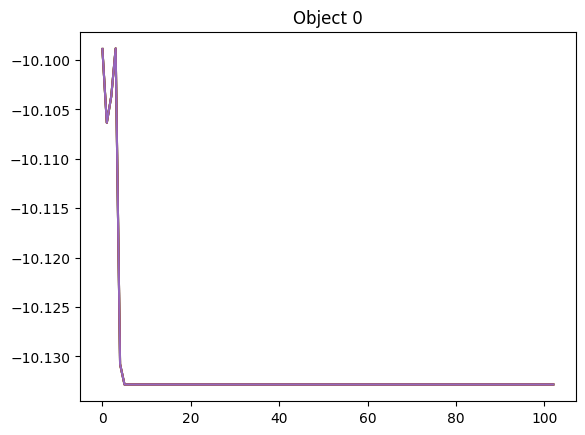

In [60]:
w = trace.project(genjax.select("pose_0"))
start = registered_objects[0]['t_full']+2
for p_id in range(w.shape[1]):
    plt.plot(w[:,p_id][start:])
plt.title("Object 0")
plt.show()

In [59]:
params = (0.05, )
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0,0,0]), *params))
b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0.2,0,0]), *params)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 params = (0.05, )                                                                            │
│ ❱ 2 display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0,0,0]), *params     │
│   3 b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0.2,0,0]), *params)          │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: logpdf() missing 1 required positional argument: 'concentration'

In [ ]:
registered_objects

In [ ]:
def get_particle_images(intrinsics_orig, inferred_poses, T, cam_pose = CAM_POSE_CV2, radius = 0.1):
    viz = o3dviz.Open3DVisualizer(intrinsics_orig)
    viz_poses = jnp.reshape(inferred_poses, (inferred_poses.shape[0], 
                inferred_poses.shape[1]*inferred_poses.shape[2],
                inferred_poses.shape[3], inferred_poses.shape[4]))
    viz_poses_world = jnp.einsum("ij,abjk->abik",cam_pose, viz_poses)
    particle_images = []
    for t in tqdm(range(T)):
        pcd = viz.make_particles(viz_poses_world[t,:,:3,3], radius = radius)
        particle_arr = viz.capture_image(intrinsics_orig,cam_pose).rgb
        particle_img = Image.fromarray(np.array(particle_arr).astype(np.uint8)[...,:3])
        particle_images.append(particle_img)
        viz.clear()
    del viz
    return particle_images

In [61]:
[(cam_pose @ inferred_poses[i,0,0])[:3,3] for i in range(131,240)]


[
    Array([9.834766e-07, 9.999550e+04, 1.499999e+00], dtype=float32),
    Array([-4.9135084 ,  3.9586868 ,  0.15495682], dtype=float32),
    Array([-5.020175  ,  3.9986868 ,  0.24829006], dtype=float32),
    Array([-4.9935083 ,  4.0253534 ,  0.24829006], dtype=float32),
    Array([-4.5668416 ,  4.0253534 ,  0.24829006], dtype=float32),
    Array([-4.366842  ,  4.0253534 ,  0.24829006], dtype=float32),
    Array([-4.2068415 ,  4.0253534 ,  0.22162342], dtype=float32),
    Array([-4.353508  ,  5.265353  ,  0.24829006], dtype=float32),
    Array([-4.086841 ,  6.4386864,  0.4482901], dtype=float32),
    Array([-3.8201742,  7.6120195,  0.2082901], dtype=float32),
    Array([-3.6601741 ,  8.852019  ,  0.19495678], dtype=float32),
    Array([-3.566841  , 10.092019  ,  0.19495678], dtype=float32),
    Array([-3.5135076 , 11.332019  ,  0.19495678], dtype=float32),
    Array([-3.486841  , 12.5720215 ,  0.19495678], dtype=float32),
    Array([-3.4735076 , 13.812023  ,  0.19495678], dtype=float

In [46]:
trace.project(genjax.select(("physics", "perturb")))[132:149]


Array([[144.75067, 143.27267, 143.02956, 144.15678, 143.5035 ],
       [145.14455, 144.22018, 145.2952 , 143.2591 , 141.74028],
       [142.3341 , 143.37096, 142.81648, 145.07912, 144.45561],
       [141.26123, 144.93074, 144.8481 , 145.67105, 144.91783],
       [142.0676 , 142.45914, 141.76787, 143.07423, 138.48564],
       [145.30444, 144.86786, 143.94206, 145.62552, 142.23468],
       [144.94586, 145.5118 , 142.83371, 143.19261, 145.10089],
       [142.20857, 144.0582 , 141.74835, 143.02312, 142.511  ],
       [143.20044, 142.19414, 144.25275, 144.98158, 142.83202],
       [142.4245 , 145.2277 , 143.09424, 140.71709, 145.74495],
       [141.56123, 141.78485, 145.28902, 143.6956 , 142.49693],
       [138.86363, 144.4361 , 143.73117, 144.12808, 142.66162],
       [145.65828, 135.81795, 143.55667, 143.88705, 143.74911],
       [144.73213, 145.15108, 144.75272, 145.62558, 144.49863],
       [144.12169, 144.26727, 143.81238, 143.70555, 143.88075],
       [143.37494, 143.85042, 143.59637

In [39]:
b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4), 1e-20, 10000.0)

Array(146.45688, dtype=float32)

In [40]:
b.gaussian_vmf_pose.logpdf(jnp.eye(4).at[:3,3].set(), jnp.eye(4), 1e-20, 10000.0)

Array(-inf, dtype=float32)